In [ ]:
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split, LeaveOneOut, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

## Кросс-валидация

Процесс обучения модели можно представить в следующем виде:

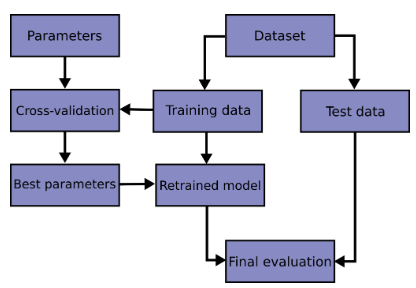

При обучении модели мы измеряем качество на тестовых данных, однако подбор моделей / гиперпараметров стоит проводить на валидационном наборе данных, а уже после финально оценивать качество на тесте.

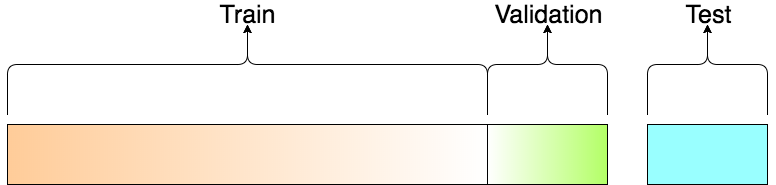

Потенциальные проблемы подхода с выделением только тестовой выборки:

*   Нарушение баланса целевой переменной / предположения о независимости объектов
*   Недостаточная емкость модели и пессимистичное смещение оценки качества
*   Точечная оценка



### Стратификация

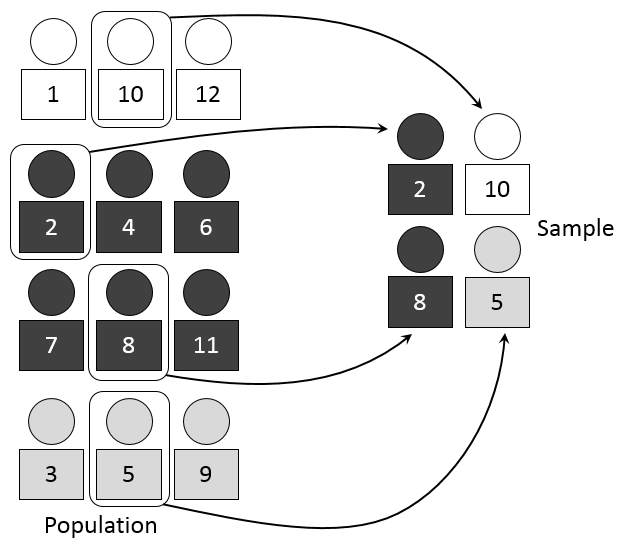

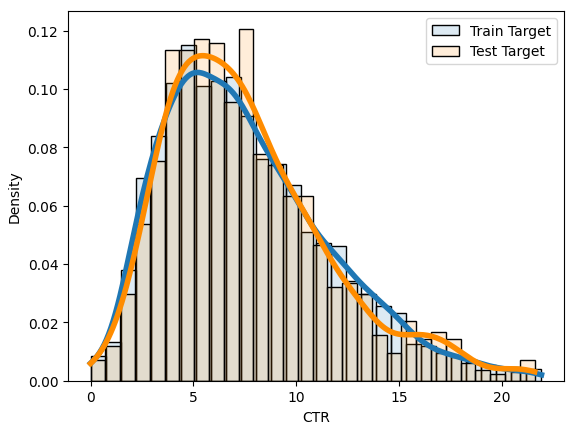

In [ ]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

y = 1 - y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.15, stratify=y) # разбиение со стратификацией

In [ ]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(target
 0    0.627329
 1    0.372671
 Name: proportion, dtype: float64,
 target
 0    0.627907
 1    0.372093
 Name: proportion, dtype: float64)

### K-Fold


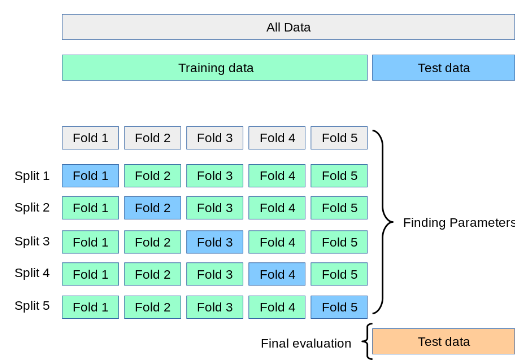

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

log_reg = LogisticRegression()
cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1')

array([1.        , 0.92957746, 0.98591549, 1.        , 0.91176471])

Альтернатива

In [ ]:
kf = KFold(n_splits=5)
for _, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
  train_data, train_label = X_train_scaled[train_index], y_train.iloc[train_index]
  val_data, val_label = X_train_scaled[val_index], y_train.iloc[val_index]

  log_reg = LogisticRegression()
  log_reg.fit(train_data, train_label)
  y_pred = log_reg.predict(val_data)
  print(f1_score(val_label, y_pred), end=', ')

1.0, 0.9210526315789473, 0.9841269841269841, 1.0, 0.9032258064516129, 

In [ ]:
skf = StratifiedKFold(n_splits=5)
for _, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
  train_data, train_label = X_train_scaled[train_index], y_train.iloc[train_index]
  val_data, val_label = X_train_scaled[val_index], y_train.iloc[val_index]

  log_reg = LogisticRegression()
  log_reg.fit(train_data, train_label)
  y_pred = log_reg.predict(val_data)
  print(f1_score(val_label, y_pred), end=', ')

1.0, 0.9295774647887324, 0.9859154929577465, 1.0, 0.9117647058823529, 

Метод k-Fold даёт более надёжную оценку качества модели, чем hold-out, так как обучение и тест модели происходят на разных подмножествах исходного датасета.

#### Как после такой валидации получить финальную модель?

- переобучить лучшую модель на всей train части
- усреднить предсказания отдельных моделей

### Leave-one-out

Метод leave-one-out является частным случаем метода k-Fold: в нём каждый фолд состоит ровно из одного семпла.

In [ ]:
loo = LeaveOneOut()
for i, (train_index, val_index) in enumerate(loo.split(X_train_scaled)):
  train_data, train_label = X_train_scaled[train_index], y_train.iloc[train_index]
  val_data, val_label = X_train_scaled[val_index], y_train.iloc[val_index]

  log_reg = LogisticRegression()
  log_reg.fit(train_data, train_label)
  y_pred = log_reg.predict(val_data)
  if i % 100 == 0:
    print(f'F1-score on fold {i}: {f1_score(val_label, y_pred, zero_division=0)}')

F1-score on fold 0: 0.0
F1-score on fold 100: 0.0
F1-score on fold 200: 1.0
F1-score on fold 300: 0.0
F1-score on fold 400: 1.0


Метод может быть полезен, если очень мало данных

### Time series cross-validation

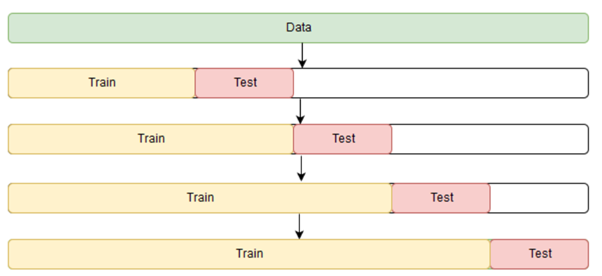

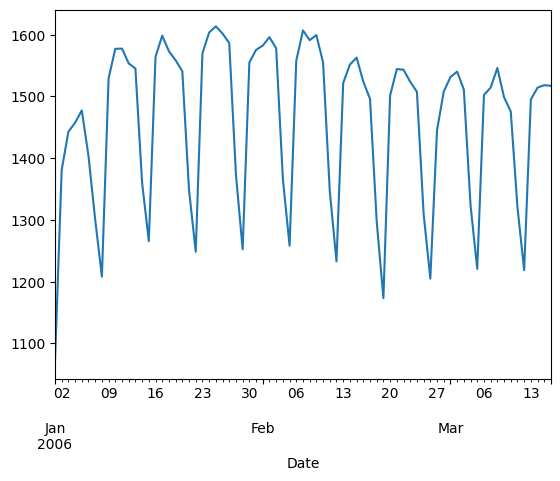

In [ ]:
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url, sep=",")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data['Consumption'].iloc[:75].plot();

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_data = data.iloc[train_index]

TRAIN: [   0    1    2 ... 1095 1096 1097] TEST: [1098 1099 1100 ... 2190 2191 2192]
TRAIN: [   0    1    2 ... 2190 2191 2192] TEST: [2193 2194 2195 ... 3285 3286 3287]
TRAIN: [   0    1    2 ... 3285 3286 3287] TEST: [3288 3289 3290 ... 4380 4381 4382]
